In [1]:
!pip install aicspylibczi

In [2]:
!pip install czifile

In [ ]:
!pip install cellpose[gui]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.2/975.2 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.5/89.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [14]:
from aicspylibczi import CziFile
import czifile
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
import time
#from cellpose import io, models

In [ ]:
!python --version

Python 3.10.12


In [7]:
from google.cloud import storage

# Create a storage client.
storage_client = storage.Client(project='jal2340-applied-cv-s24')

# Specify the name of your GCS bucket and the object (file) to download.
bucket_name = '3d-dicty-data'

bucket = storage_client.bucket(bucket_name)

In [8]:
# exp is experiment/ collection dates
exp_dates = ['2023-01-30', '2023-10-25']
blobs = {
    exp_dates[0] : {"MIP" : [], "raw": [], "processed":[]},
    exp_dates[1] : dict(raw=[], MIP=[], smiley=[]),
}
for blob in bucket.list_blobs():
  if(exp_dates[0] in blob.name):
    if('MIP.czi' in blob.name):
      blobs[exp_dates[0]]["MIP"].append(blob)
    elif("processed.czi" in blob.name):
      blobs[exp_dates[0]]["processed"].append(blob)
    else:
      blobs[exp_dates[0]]["raw"].append(blob)
  elif(exp_dates[1] in blob.name):
    if('MIP.czi' in blob.name):
      blobs[exp_dates[1]]["MIP"].append(blob)
    elif("smiley.czi" in blob.name):
      blobs[exp_dates[1]]["smiley"].append(blob)
    else:
      blobs[exp_dates[1]]["raw"].append(blob)

In [9]:
blobs

{'2023-01-30': {'MIP': [<Blob: 3d-dicty-data, 2023-01-30/dicty_factin_pip3-01_MIP.czi, 1710358500008774>,
   <Blob: 3d-dicty-data, 2023-01-30/dicty_factin_pip3-02_MIP.czi, 1710358537771887>,
   <Blob: 3d-dicty-data, 2023-01-30/dicty_factin_pip3-03_MIP.czi, 1710358751673597>,
   <Blob: 3d-dicty-data, 2023-01-30/dicty_factin_pip3-04_MIP.czi, 1710358795150245>,
   <Blob: 3d-dicty-data, 2023-01-30/dicty_factin_pip3-05_MIP.czi, 1710358946480650>,
   <Blob: 3d-dicty-data, 2023-01-30/dicty_factin_pip3-06_MIP.czi, 1710361694382886>,
   <Blob: 3d-dicty-data, 2023-01-30/dicty_factin_pip3-07_MIP.czi, 1710366852425136>,
   <Blob: 3d-dicty-data, 2023-01-30/dicty_factin_pip3-08_MIP.czi, 1710367004956447>,
   <Blob: 3d-dicty-data, 2023-01-30/dicty_factin_pip3-09_MIP.czi, 1710369513010511>],
  'raw': [<Blob: 3d-dicty-data, 2023-01-30/dicty_factin_pip3-01.czi, 1710358579678619>,
   <Blob: 3d-dicty-data, 2023-01-30/dicty_factin_pip3-02.czi, 1710358536343239>,
   <Blob: 3d-dicty-data, 2023-01-30/dicty_fa

In [ ]:
# index is which video choosing (6th one, etc)

def get_image(vid_index, date=0, group='processed', blobs=blobs):
  blob = blobs[exp_dates[date]][group][vid_index]
  fname = blob.name.split('/')[-1] # ignore date/fname
  print(f"Loading {fname}")
  blob.download_to_filename(fname)
  return(CziFile(fname))

In [10]:
blob = blobs[exp_dates[0]]['processed'][5]
blob.size / (1024 * 1024 * 1024) # size in GB

99.62492406368256

In [11]:
chunk_size=10*1024*1024

In [13]:
start = 0
end = min(start + chunk_size, blob.size)
print(f"Loading {start} to {end}")
blob.download_as_string(start=start, end=end)

Loading 0 to 10485760


In [ ]:
# Read the blob in chunks
start = 0
while start < blob_size:
    end = min(start + chunk_size, blob_size)
    chunk = blob.download_as_string(start=start, end=end)
    process_czi_chunk(chunk)
    start = end

In [ ]:
def process_czi_chunk(chunk):
    # Process the chunk as needed
    pass

def load_czi_from_gcs(bucket_name, blob_name, chunk_size=10*1024*1024):  # Chunk size: 10 MB
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    # Get the total size of the blob
    blob_size = blob.size

    # Read the blob in chunks
    start = 0
    while start < blob_size:
        end = min(start + chunk_size, blob_size)
        chunk = blob.download_as_string(start=start, end=end)
        process_czi_chunk(chunk)
        start = end

# Example usage:
bucket_name = 'your_bucket_name'
blob_name = 'path/to/your/czi/video/file.czi'
load_czi_from_gcs(bucket_name, blob_name)

In [24]:
img = get_image(5, 0, 'processed')
# TODO: Understand each dimension in the shape
# shape is Channels x num_slices x H x W.
# S is "Scene" - different POV or regions
# not a video ??
img.get_dims_shape()

Loading dicty_factin_pip3-06_processed.czi


OSError: [Errno 28] No space left on device

In [21]:
!ls

dicty_factin_pip3-01.czi  dicty_factin_pip3-05_processed.czi  New-04.czi


## Cell Segmentation

In [ ]:
img_input = img[0, 50, :, :]

In [ ]:
masks, flows, styles = models.CellposeModel(model_type='cyto3').eval(img_input,
                            diameter=None, channels=[0,0])

In [ ]:
plt.imshow(img[0, 50, :, :])

In [ ]:
masks.unique()

In [ ]:
plt.imshow(masks == 20)

In [ ]:
def get_zslice(img, z, channel=0):
  return(img[channel, z, :, :])


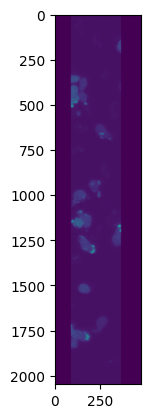

In [ ]:
plt.imshow(get_zslice(img, 50))

## Dataloader

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class CziVideoDataset(Dataset):
    def __init__(self, fpaths, frame_split=[16,16], n=0, channel=0):
        if(type(fpaths) == list):
            arrs = []
            for fpath in fpaths:
                data = czifile.imread(fpath).squeeze() # once we get multiple files, must combine
                arrs.append(data)
            data = np.concatenate(arrs, axis=0)
        else:
            data = czifile.imread(fpaths).squeeze()

        if(n>0): # if do not set, use entire dataset (like transformer)
            self.n = int(n) # n grams frame prediction
        else:
            self.n = 0

        print(f"Data with {len(data)} frames")
        self.patches_per_frame = frame_split[0] * frame_split[1]
        self.grid_size = frame_split
        self.frames = data[:,channel, :, :].astype(np.float32)
        self.frame_tensors = torch.tensor(self.frames, dtype=torch.float32).clone().detach()

    def __len__(self):
        # THIS MIGHT NOT BE TRUE
        # reasoning is that if 10 frames, trigram model, first frame possible is 8. (8,9), 10
        return((len(self.frames) - self.n + 1) * self.patches_per_frame)

    def __getitem__(self, idx):
        # indexes at max max-n frames
        first_frame = idx//self.patches_per_frame
        patch_index = idx%self.patches_per_frame
        print(f"first frame at {first_frame}, patch {patch_index}")
        if(self.n>0):
            Xs = []
            for i in range(self.n-1):
                patch = self.get_patch(first_frame+i, patch_index)
                print(patch.shape)
                Xs.append(patch)
            X = torch.cat(Xs, dim=0)
            print(X.shape)
            y = self.get_patch(first_frame + self.n - 1, patch_index)
            return(torch.flatten(X), torch.flatten(y))
        else:
            raise NotImplementedError

    def get_patch(self, frame_index, patch):
        arr = self.frame_tensors[frame_index]
        assert patch < self.patches_per_frame, "Patch index out of range"
        height, width = arr.shape
        #print(height, width)
        row_size, col_size = int(height / self.grid_size[0]), int(width/self.grid_size[1])
        patch_row, patch_col = int(patch/self.grid_size[1]), patch%self.grid_size[1] # [0 1 2; 3 4 5; 6 7 8]
        #print(f"Row {patch_row}, ({row_size}px), Col {patch_col}, ({col_size}px)")
        return(arr[row_size*patch_row:row_size*(patch_row+1), col_size*patch_col:col_size*(patch_col+1)])

    def reshape_flattened(self, flattened_patch):
        # turn input flattened vector back into frames for viewing (heightxwidthxnum_frames)
        frame_height, frame_width = self.frames[0].shape
        patch_height, patch_width = frame_height // self.grid_size[0], frame_width // self.grid_size[1]
        return(flattened_patch.reshape([patch_height, patch_width, -1]))



In [ ]:
%%time
ds = CziVideoDataset(fname, [16, 4], n=3)

Data with 224 frames
CPU times: user 1.37 s, sys: 6.81 s, total: 8.19 s
Wall time: 4.21 s


In [ ]:
X, y = getitem(ds, 4)

first frame at 0, patch 4
torch.Size([128, 281])
torch.Size([128, 281])
torch.Size([256, 281])


In [ ]:
len(ds)

14144

In [ ]:
X.reshape([128, 281, -1]).shape

torch.Size([128, 281, 2])

In [ ]:
dataloader = DataLoader(ds, batch_size=16, shuffle=True)

In [ ]:
ds[10].shape

frame 0, patch 10


torch.Size([35968])

### Saving Videos

In [ ]:
def save_as_video(self, output_path):
    s = time.time()
    # Define the video codec and frames per second (fps)
    height, width = self.frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    fps = 30
    # Create a VideoWriter object
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=False)
    for frame in self.frames:
        video_writer.write(frame)
    video_writer.release()

    print(f"Video saved to: {output_path} in {time.time() - s} seconds")

def save2(self, fname):
    fps = 30
    # Write frames to the video file
    with imageio.get_writer(fname, fps=fps) as writer:
        for frame in self.frames:
            writer.append_data(frame)
    print(f"Video saved to: {fname} in {time.time() - s} seconds")

In [ ]:
fpath = "test.mp4"
fps = 30
with imageio.get_writer(fpath) as writer:
    writer.fps = fps  # Set the frame rate
    for frame in ds.frames[:10]:
        writer.append_data(frame)


## Computing Optical Flow

In [22]:
## Importing the necessary modules
import numpy as np
import os
import skimage.io as io
from natsort import natsorted
from tqdm import tqdm
import scipy as sp
import time
import scipy.io as sio
#import hdf5storage
from multiprocessing import TimeoutError
from multiprocessing.pool import ThreadPool as Pool
from functools import partial
import matplotlib.pyplot as plt
from aicspylibczi import CziFile
import warnings
warnings.filterwarnings("ignore")

In [ ]:
## Load Data

# Folder address where the raw 3D movie is
data_folder = 'E:\\Spandan\\3D_Lattice_Lightsheet\\Shen 1-30-23\\dicty_factin_pip3-06_processed'
czi_path = data_folder +'\\dicty_factin_pip3-06_processed.czi'

input_img = CziFile(czi_path)
shape = input_img.size; dims = input_img.dims;  # Check shape of the data
print(shape), print(dims)

num_timepoints, num_stacks, height, width = shape[1], shape[3], shape[4], shape[5]

In [ ]:
def smoothing(k, img):

    def pre_processing(frm_id, image, ch_id):
        img_temp = image.read_image(T=frm_id, C=ch_id)
        imge = np.squeeze(img_temp[0])
        return imge

    current_frame = pre_processing(k, img, channel)

    if k == start_frame or k == end_frame - jump:
        result = current_frame
    else:
        previous_frame = pre_processing(k - jump, img, channel)
        next_frame = pre_processing(k + jump, img, channel)

        if k == start_frame + jump or k == end_frame - 2*jump:
            result = np.average([previous_frame, current_frame, next_frame], weights=kernel1, axis=0)

        else:
            frame_minus_2_jump = pre_processing(k - 2 * jump, img, channel)
            frame_plus_2_jump = pre_processing(k + 2 * jump, img, channel)
            result = np.average([frame_minus_2_jump, previous_frame, current_frame, next_frame, frame_plus_2_jump], weights=kernel2, axis=0)

    result = result.astype(np.float32)
    np.save(os.path.join(data_folder, 'smoothed_frames', f'{k}'), result)

# Example usage:
jump = 1
start_frame = 0
end_frame = num_timepoints
channel = 0
# Create a local folder for storing smoothed frames
os.makedirs(os.path.join(data_folder, 'smoothed_frames'), exist_ok=True)

In [ ]:
kernel1 = np.array([0.225,0.55,0.225]);
kernel2 = np.array([0.036,0.249,0.431,0.249,0.036])

numProcessors = 16   # maybe change it to 8 (but that's it!)
pool = Pool(processes=numProcessors)

print('Post-processing in parallel with '+str(numProcessors)+' processors')

#store start time
stopwatchStart = time.time()
[temp] =zip(*pool.map(partial(smoothing, img = input_img), range(num_timepoints-1)))

print('Wall time = '+str(np.round(time.time() - stopwatchStart,2))+' s')

print('Parallel post processing complete, switching to serial')
pool.close()

In [ ]:
# Lucas-Kanade method for Optical Flow
# INPUTS:

#k: Timeframe index, input_image: temporally smoothed movie
#sig: Spread of the Gaussian weights around a pixel, #thresh: Threshold for reliability score

# OUTPUTS (stored in a data file):
#vx: x-velocity, vy: y-velocity, vz: z-velocity
#reliabMat: reliability score for velocities calculated at a pixel (higher the better)

def LKxOptFlow(k,sig,thresh):

    def reliability_from_cubic_roots(a,b,c,d,e,f):
        trA = a + b + c;
        q = trA/3;
        x = (a + b - 2*c)**2/9 + (a -2*b + c)**2/9 + (b - 2*a + c)**2/9 + 2*(d**2 + e**2 + f**2);
        p = np.sqrt(x/6)
        detB = ((a-q)*(b-q)*(c-q) + 2*d*e*f - (a-q)*f**2 - (b-q)*e**2 - (c-q)*d**2)/(p**3)
        detB[detB > 2] = 2;
        detB[detB < -2] = -2;

        theta = np.arccos(detB/2)/3

        # define roots
        r1 = 2*np.cos(theta);
        r2 = 2*np.cos(theta + 2*np.pi/3);
        r3 = 2*np.cos(theta + 4*np.pi/3);

        # define eigs
        b1 = r1*p + q;
        b2 = r2*p + q;
        b3 = r3*p + q;

        # define reliability
        rel = np.stack((b1,b2,b3), axis=3)
        rel = np.min(rel, axis=3)
        return rel


    current_frame = np.load(smooth_address+'\\{}.npy'.format(k))             # Load temporally smoothed frame-1
    next_frame = np.load(smooth_address+'\\{}.npy'.format(k+1))         # Load temporally smoothed frame-2

    # Calculating the spatial and temporal gradients assuming the input frame is of the shape (ZYX)

    dy = np.gradient(current_frame,axis=1,edge_order=1)
    dx = np.gradient(current_frame,axis=2,edge_order=1)
    dz = np.gradient(current_frame,axis=0,edge_order=1)
    dt = next_frame - current_frame

    dz = dz.astype(np.float32); dy = dy.astype(np.float32); dx = dx.astype(np.float32); dt = dt.astype(np.float32);

    wdx2 = sp.ndimage.gaussian_filter(dx**2, sig, mode='nearest')
    wdy2 = sp.ndimage.gaussian_filter(dy**2, sig, mode='nearest')
    wdz2 = sp.ndimage.gaussian_filter(dz**2, sig, mode='nearest')

    wdxy = sp.ndimage.gaussian_filter(dx*dy, sig, mode='nearest')
    wdxz = sp.ndimage.gaussian_filter(dx*dz, sig, mode='nearest')
    wdyz = sp.ndimage.gaussian_filter(dy*dz, sig, mode='nearest')

    wdtx = sp.ndimage.gaussian_filter(dx*dt, sig, mode='nearest')
    wdty = sp.ndimage.gaussian_filter(dy*dt, sig, mode='nearest')
    wdtz = sp.ndimage.gaussian_filter(dz*dt, sig, mode='nearest')

    # Calculate Flow
    eps = 1e-6
    determinant = wdx2*wdy2*wdz2 + 2*wdxy*wdyz*wdxz - wdx2*(wdyz**2) - wdy2*(wdxz**2) - wdz2*(wdxy**2)

    vx = -((determinant + eps)**(-1))* ( \
              wdtx*(wdy2*wdz2 - wdyz**2) \
            + wdty*(wdxz*wdyz - wdxy*wdz2) \
            + wdtz*(wdxy*wdyz - wdxz*wdy2) );
    vy = -((determinant + eps)**(-1))* ( \
              wdtx*(wdxz*wdyz - wdxy*wdz2) \
            + wdty*(wdx2*wdz2 - wdxz**2) \
            + wdtz*(wdxy*wdxz - wdx2*wdyz) );
    vz = -((determinant + eps)**(-1))* ( \
              wdtx*(wdxy*wdyz - wdxz*wdy2) \
            + wdty*(wdxy*wdxz - wdx2*wdyz) \
            + wdtz*(wdx2*wdy2 - wdxy**2) );
    reliabMat = reliability_from_cubic_roots(wdx2,wdy2,wdz2,wdxy,wdxz,wdyz)

    vx = vx*(reliabMat > thresh);
    vy = vy*(reliabMat > thresh);
    vz = vz*(reliabMat > thresh);

#     np.savez(save_path+'/{}.npz'.format(k),vx = vx,vy = vy,rel=reliabMat)   # to save as numpy data files
    sio.savemat(save_path+'\\{}.mat'.format(k),{'vx':vx,'vy':vy,'vz':vz,'rel':reliabMat},do_compression=False) # to save as .MAT files
    return [0]

In [ ]:
# Example usage:

data_folder = 'E:\\Spandan\\3D_Lattice_Lightsheet\\Shen 1-30-23\\dicty_factin_pip3-06_processed'   # Root address where all the images are stored
smooth_address = data_folder+'\\smoothed_frames'
save_path = data_folder+'\\Op_flow_threaded'                 # Create a local folder for storing OF results
os.makedirs(save_path,exist_ok=True)

file_list = natsorted(os.listdir(smooth_address))    # sort the image files numerically by frame-index
n_frames = len(file_list);

In [ ]:
numProcessors = 16   # maybe change it to 8 (but that's it)
pool = Pool(processes=numProcessors)

print('Post-processing in parallel with '+str(numProcessors)+' processors')

#store start time
stopwatchStart = time.time()
[temp] =zip(*pool.map(partial(LKxOptFlow, sig = 2, thresh = 0.1), range(n_frames-1)))

print('Wall time = '+str(np.round(time.time() - stopwatchStart,2))+' s')

print('Parallel post processing complete, switching to serial')
pool.close()